In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


df=pd.read_csv("/home/slisowski/Pobrane/clean_stock_sentiment_data.csv", index_col=0)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8634 entries, 0 to 8633
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       8634 non-null   object
 1   sentiment  8634 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 202.4+ KB


In [24]:
from sklearn.linear_model import LogisticRegression


In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
vect_bigram=CountVectorizer(ngram_range=(1,2)).fit(df.text)
X_ngram=vect_bigram.transform(df.text)
df_ngram=pd.DataFrame(X_ngram.todense(), columns=vect_bigram.get_feature_names())

/home/slisowski/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [33]:
y=df['sentiment']
X=df_ngram
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3, random_state=42)
log_reg=LogisticRegression().fit(X_train,y_train)
log_reg.score(X_train,y_train)
y_predicted=log_reg.predict(X_test)
accuracy_score(y_test, y_predicted)

/home/slisowski/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7981474334233887

In [34]:
f1_score(y_test, y_predicted)

0.8529659825695811

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predicted)

array([[ 551,  364],
       [ 159, 1517]])

In [36]:
preds=log_reg.predict_proba(X_test)

In [37]:
tn, fp, fn, tp=confusion_matrix(y_test, y_predicted).ravel()

In [38]:
tn

551

In [39]:
fp

364

In [40]:
fn

159

In [41]:
tp

1517

In [42]:
precision_score(y_test, y_predicted)

0.8064859117490697

In [43]:
recall_score(y_test, y_predicted)

0.9051312649164678

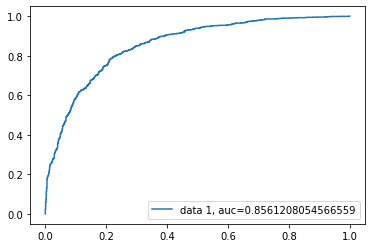

In [44]:
from sklearn import metrics
import matplotlib.pyplot as plt
y_pred_proba = log_reg.predict_proba(X_test)[:,1]
fpr, tpr, proba = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [45]:
optimal_proba_cutoff = sorted(list(zip(np.abs(tpr - fpr), proba)), key=lambda i: i[0], reverse=True)[0][1]

In [46]:
optimal_proba_cutoff

0.6675145656169936

In [47]:
y_pred_proba

array([0.87242626, 0.65421653, 0.51640419, ..., 0.68751833, 0.22959295,
       0.03546412])

In [48]:
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in y_pred_proba]

In [49]:
print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(y_test, y_predicted), accuracy_score(y_test, roc_predictions)))
print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(y_test, y_predicted), precision_score(y_test, roc_predictions)))
print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(y_test, y_predicted), recall_score(y_test, roc_predictions)))
print("F1 Score Before and After Thresholding: {}, {}".format(f1_score(y_test, y_predicted), f1_score(y_test, roc_predictions)))

Accuracy Score Before and After Thresholding: 0.7981474334233887, 0.7881126978000772
Precision Score Before and After Thresholding: 0.8064859117490697, 0.867579908675799
Recall Score Before and After Thresholding: 0.9051312649164678, 0.7935560859188544
F1 Score Before and After Thresholding: 0.8529659825695811, 0.8289186662511686


In [29]:
import pandas as pd  
import numpy as np
from bs4 import BeautifulSoup
import preprocessor as p
import re
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    text=demoji.replace(text," ")
    text=p.clean(text)
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()
news="As inflation slows and the ruble down, Russia is hoping to get a financial crisis"
news_clean=tweet_cleaner(news)


In [30]:
cv=CountVectorizer(ngram_range=(1,2))
cvdf=cv.fit_transform(df.text)
vc=pd.DataFrame(cv.transform([news_clean]).toarray())
new_data=pd.DataFrame(vc)
log_reg.predict(new_data)

/home/slisowski/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0])

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect=TfidfVectorizer(ngram_range=(1,2)).fit(df.text)
X_tfidf=tfidf_vect.transform(df.text)
df_tfidf=pd.DataFrame(X_tfidf.todense(), columns=tfidf_vect.get_feature_names())


/home/slisowski/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [59]:
df_tfidf['enter']

0       0.149737
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
8629    0.000000
8630    0.000000
8631    0.000000
8632    0.000000
8633    0.000000
Name: enter, Length: 8634, dtype: float64

In [60]:
y=df['sentiment']
X=df_tfidf
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3, random_state=42)
log_reg=LogisticRegression().fit(X_train,y_train)
log_reg.score(X_train,y_train)
y_predicted=log_reg.predict(X_test)
accuracy_score(y_test, y_predicted)

0.7491316094172135

In [61]:
confusion_matrix(y_test, y_predicted)

array([[ 310,  605],
       [  45, 1631]])